In [1]:
!pip install python-box timm pytorch-lightning ttach torchmetrics torchtoolbox albumentations wandb -q

You should consider upgrading via the '/usr/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
!rm -r cait_m36_384

rm: cannot remove 'cait_m36_384': No such file or directory


In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
import os
import warnings
from pprint import pprint
from glob import glob
from tqdm import tqdm
import torchmetrics

import numpy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from box import Box
from timm import create_model
from sklearn.model_selection import StratifiedKFold
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image


import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import LightningDataModule, LightningModule


warnings.filterwarnings("ignore")

In [5]:
print(torch.__version__)

1.10.0+cu113


In [6]:
# import timm
# timm.list_models(pretrained=True)

## config

In [7]:
# !rm ./convit_base -r

In [8]:
config = {'seed': 42,
          'root': '/hy-tmp', 
          'n_splits': 5,
          'epoch': 30,
          'trainer': {
              'gpus': 1,
              'accumulate_grad_batches': 4,
              'progress_bar_refresh_rate': 0,
              'fast_dev_run': False,
              'num_sanity_val_steps': 0,
              'resume_from_checkpoint': None,
          },
          'transform':{
              'name': 'get_default_transforms',
              'image_size': 384
          },
          'train_loader':{
              'batch_size': 4,
              'shuffle': True,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': True,
          },
          'val_loader': {
              'batch_size': 8,
              'shuffle': False,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': False
         },
          'model':{
              'name': 'cait_m36_384',
              'output_dim': 6
          },
          'optimizer':{
              'name': 'optim.AdamW',
              'params':{
                  'lr': 1e-5
              },
          },
          'scheduler':{
              'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
              'params':{
                  'T_0': 20,
                  'eta_min': 3e-6,
              }
          },
          'loss': 'nn.CrossEntropyLoss',
}

config = Box(config)

In [9]:
pprint(config)

{'epoch': 30,
 'loss': 'nn.CrossEntropyLoss',
 'model': Box({'name': 'cait_m36_384', 'output_dim': 6}),
 'n_splits': 5,
 'optimizer': Box({'name': 'optim.AdamW', 'params': {'lr': 1e-05}}),
 'root': '/hy-tmp',
 'scheduler': {'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
               'params': Box({'T_0': 20, 'eta_min': 3e-06})},
 'seed': 42,
 'train_loader': {'batch_size': 4,
                  'drop_last': True,
                  'num_workers': 4,
                  'pin_memory': False,
                  'shuffle': True},
 'trainer': {'accumulate_grad_batches': 4,
             'fast_dev_run': False,
             'gpus': 1,
             'num_sanity_val_steps': 0,
             'progress_bar_refresh_rate': 0,
             'resume_from_checkpoint': None},
 'transform': Box({'name': 'get_default_transforms', 'image_size': 384}),
 'val_loader': {'batch_size': 8,
                'drop_last': False,
                'num_workers': 4,
                'pin_memory': False,
            

## dataset

In [10]:
class EMSIGDataset(Dataset):
    def __init__(self, df, image_size=384, transform=None):
        self._X = df["id"].values
        self._y = None
        if "target" in df.keys():
            self._y = df["target"].values
#         self._transform = T.Resize([image_size, image_size])
        self._transform = transform

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        image_path = self._X[idx]
#         image = read_image(image_path)
#         image = self._transform(image)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = self._transform(image=image)
#         print('augment')
        image = augmented['image']
#         print('augmented ')
        if self._y is not None:
            label = self._y[idx]
            return image, label
        return image

class EMSIGDataModule(LightningDataModule):
    def __init__(
        self,
        train_df,
        val_df,
        cfg,
    ):
        super().__init__()
        self._train_df = train_df
        self._val_df = val_df
        self._cfg = cfg

    def __create_dataset(self, train=True):
        return (
            EMSIGDataset(self._train_df, self._cfg.transform.image_size, transform = get_default_transforms()['train'])
            if train
            else EMSIGDataset(self._val_df, self._cfg.transform.image_size, transform = get_default_transforms()['val'])
        )

    def train_dataloader(self):
        dataset = self.__create_dataset(True)
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = self.__create_dataset(False)
        return DataLoader(dataset, **self._cfg.val_loader)

## visualize data

In [11]:
torch.autograd.set_detect_anomaly(True)
seed_everything(config.seed)

df = pd.read_csv('/hy-tmp/train_labels.csv')
df["id"] = df["id"].apply(lambda x: os.path.join(config.root, "crop_spectrum_train_pic", x))

Global seed set to 42


In [12]:
df['target'] = df['target'] - 1

## augmentation

In [13]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.384, 0.225]  # RGB
IMAGE_SIZE = config.transform.image_size

def get_default_transforms():
    transform = {
        "train": A.Compose(
            [
                A.Resize(IMAGE_SIZE, IMAGE_SIZE),
#                 A.Cutout(num_holes=1, max_h_size=IMAGE_SIZE, max_w_size=int(IMAGE_SIZE/8)),
#                 A.Cutout(num_holes=1, max_h_size=int(IMAGE_SIZE/8), max_w_size=IMAGE_SIZE),
                A.CoarseDropout(max_holes=2, max_height=IMAGE_SIZE, max_width=int(IMAGE_SIZE/8), min_holes=1, min_height=None, min_width=int(IMAGE_SIZE/16), fill_value=[0, 0, 225]),
                A.CoarseDropout(max_holes=2, max_height=int(IMAGE_SIZE/8), max_width=IMAGE_SIZE, min_holes=1, min_height=int(IMAGE_SIZE/16), min_width=None, fill_value=[0, 0, 225]),
                A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ToTensorV2(),
            ]
        ),
        "val": A.Compose(
            [
                A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ToTensorV2()
            ]
        ),
    }
    return transform


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


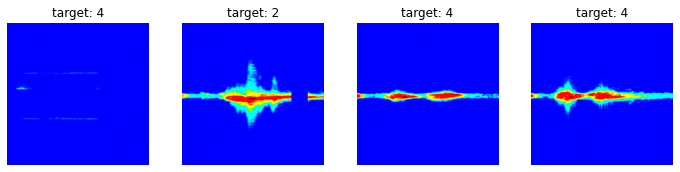

In [14]:
sample_dataloader = EMSIGDataModule(df, df, config).train_dataloader()
images, labels = iter(sample_dataloader).next()

plt.figure(figsize=(12, 12))
for it, (image, label) in enumerate(zip(images[:16], labels[:16])):
    plt.subplot(4, 4, it+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'target: {int(label)}')

## model

In [15]:
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

In [16]:
fuc = get_default_transforms()['train']

In [17]:
class Model(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self._criterion = eval(self.cfg.loss)()
        self.transform = get_default_transforms()
        self.save_hyperparameters(cfg)

    def __build_model(self):
        self.backbone = create_model(
            self.cfg.model.name, pretrained=True, num_classes=0, in_chans=3
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5), 
            nn.Linear(self.backbone.num_features, 64),
            nn.Dropout(0.5), 
            nn.Linear(64, self.cfg.model.output_dim)
        )
        

    def forward(self, x):
        f = self.backbone(x)
        out = self.fc(f)
        return out

    def training_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'train')
        # print('train loss: ', loss)
        return {'loss': loss, 'pred': pred, 'labels': labels}
        
    def validation_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'val')
        # print('valid loss: ', loss)
        return {'pred': pred, 'labels': labels}
    
    def __share_step(self, batch, mode):
        images, labels = batch
#         labels = labels.float() / 100.0
#         print(images.detach().cpu().numpy())
#         images = self.transform[mode](image)
    
    # mixup
        # if torch.rand(1)[0] < 0.5 and mode == 'train':
        #     mix_images, target_a, target_b, lam = mixup(images, labels, alpha=0.5)
        #     pred = self.forward(mix_images)
        #     loss = self._criterion(pred, target_a) * lam + \
        #         (1 - lam) * self._criterion(pred, target_b)
        # else:
        #     pred = self.forward(images)
        #     loss = self._criterion(pred, labels)
        
        pred = self.forward(images)
        loss = self._criterion(pred, labels)
        
        pred_cpu = pred.detach().cpu()# * 100.
        labels = labels.detach().cpu()# * 100.
        return loss, pred_cpu, labels
        
    def training_epoch_end(self, outputs):
        print('-----train-----')
        self.__share_epoch_end(outputs, 'train')

    def validation_epoch_end(self, outputs):
        print('-----valid-----')
        self.__share_epoch_end(outputs, 'val')    
        
    def __share_epoch_end(self, outputs, mode):
        preds = []
        labels = []
        for out in outputs:
            pred, label = out['pred'], out['labels']
            preds.append(pred)
            labels.append(label)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        loss = self._criterion(preds, labels)
        metrics = torchmetrics.functional.accuracy(preds, labels, average='macro', num_classes=6)
        sfmx = nn.Softmax(dim = 1)
        preds_prob = sfmx(preds)
        cm = torchmetrics.functional.confusion_matrix(preds_prob, labels, num_classes=6, normalize=None, threshold=0.5, multilabel=False)
        print(cm.numpy().tolist())
        print('Accuracy： ', float(metrics.numpy()))
        print('Epoch loss: ', float(loss.numpy()))
        self.log(f'Fold_{FOLD}_{mode}_loss', float(loss.numpy()))
        self.log(f'{mode}_loss', float(loss.numpy()))
        self.log(f'Fold_{FOLD}_{mode}_acc', float(metrics.numpy()))
    

    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )
        scheduler = eval(self.cfg.scheduler.name)(
            optimizer,
            **self.cfg.scheduler.params
        )
        return [optimizer], [scheduler]

## train

In [18]:
%%time

skf = StratifiedKFold(
    n_splits=config.n_splits, shuffle=True, random_state=config.seed
)

FOLD = 0

for fold, (train_idx, val_idx) in enumerate(skf.split(df["id"], df["target"])):
    print('FOLD: ', FOLD)
    train_df = df.loc[train_idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)
#     train_name = 'train' + str(FOLD) + '.csv'
#     valid_name = 'valid' + str(FOLD) + '.csv'
#     train_df.to_csv(train_name)
#     val_df.to_csv(valid_name)
    datamodule = EMSIGDataModule(train_df, val_df, config)
    model = Model(config)
    earystopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    lr_monitor = callbacks.LearningRateMonitor()
    loss_checkpoint = callbacks.ModelCheckpoint(
        filename="best_loss",
        monitor="val_loss",
        save_top_k=1,
        mode="min",
        save_last=False,
    )
    logger = WandbLogger(project='cait-no-mixup',
                         log_model=False)
    
    trainer = pl.Trainer(
        logger=logger,
        max_epochs=config.epoch,
        callbacks= earystopping,
        **config.trainer,
    )
    trainer.fit(model, datamodule=datamodule)
    # PATH = './' + str(fold)
    # torch.save(model.state_dict(), PATH)
    FOLD += 1

FOLD:  0


wandb: Currently logged in as: bingliangli (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | Cait             | 270 M 
1 | fc         | Sequential       | 49.6 K
2 | _criterion | CrossEntropyLoss | 0     
------------------------------------------------
270 M     Trainable params
0         Non-trainable params
270 M     Total params
1,082.008 Total estimated model params size (MB)


-----valid-----
[[62, 0, 0, 0, 1, 0], [1, 53, 0, 2, 6, 0], [4, 32, 9, 0, 18, 0], [0, 6, 0, 40, 15, 0], [0, 2, 0, 7, 52, 1], [0, 0, 0, 1, 1, 38]]
Accuracy：  0.7377117872238159
Epoch loss:  0.8029412031173706
-----train-----
[[156, 20, 24, 22, 13, 14], [18, 83, 45, 48, 29, 26], [14, 57, 56, 64, 46, 11], [13, 42, 25, 83, 65, 20], [14, 28, 22, 57, 108, 19], [9, 16, 16, 32, 13, 72]]
Accuracy：  0.4019172191619873
Epoch loss:  1.4892046451568604
-----valid-----
[[62, 0, 0, 0, 1, 0], [0, 59, 1, 1, 1, 0], [0, 0, 61, 1, 1, 0], [0, 2, 0, 50, 9, 0], [0, 0, 0, 11, 50, 1], [0, 0, 1, 0, 1, 38]]
Accuracy：  0.9133529663085938
Epoch loss:  0.3209819793701172
-----train-----
[[245, 0, 3, 1, 0, 0], [1, 207, 24, 10, 8, 0], [4, 31, 149, 28, 28, 8], [3, 14, 23, 129, 76, 3], [3, 4, 21, 48, 171, 1], [0, 0, 3, 3, 2, 149]]
Accuracy：  0.7619107365608215
Epoch loss:  0.7266809940338135
-----valid-----
[[62, 0, 0, 0, 1, 0], [0, 59, 1, 1, 1, 0], [0, 0, 63, 0, 0, 0], [0, 1, 0, 50, 9, 1], [0, 0, 1, 9, 51, 1], [0, 0, 0

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | Cait             | 270 M 
1 | fc         | Sequential       | 49.6 K
2 | _criterion | CrossEntropyLoss | 0     
------------------------------------------------
270 M     Trainable params
0         Non-trainable params
270 M     Total params
1,082.008 Total estimated model params size (MB)


-----valid-----
[[62, 0, 1, 0, 0, 0], [0, 56, 1, 1, 5, 0], [0, 0, 51, 0, 8, 3], [0, 0, 12, 23, 26, 1], [0, 0, 6, 1, 55, 0], [0, 0, 0, 0, 0, 39]]
Accuracy：  0.8256102204322815
Epoch loss:  0.8507474064826965
-----train-----
[[171, 25, 32, 11, 6, 4], [13, 80, 44, 61, 40, 11], [14, 41, 75, 53, 48, 17], [7, 47, 41, 82, 55, 15], [4, 31, 49, 47, 100, 17], [4, 8, 32, 17, 29, 69]]
Accuracy：  0.41327059268951416
Epoch loss:  1.4882383346557617
-----valid-----
[[63, 0, 0, 0, 0, 0], [0, 62, 0, 0, 1, 0], [0, 3, 57, 2, 0, 0], [0, 4, 4, 45, 9, 0], [0, 2, 0, 14, 46, 0], [0, 0, 0, 0, 0, 39]]
Accuracy：  0.8952039480209351
Epoch loss:  0.36677607893943787
-----train-----
[[245, 2, 1, 0, 0, 0], [1, 202, 7, 25, 12, 2], [2, 11, 195, 15, 20, 6], [0, 19, 40, 127, 58, 3], [1, 11, 20, 51, 161, 4], [0, 0, 6, 3, 2, 148]]
Accuracy：  0.7794103622436523
Epoch loss:  0.7287291288375854
-----valid-----
[[63, 0, 0, 0, 0, 0], [0, 62, 0, 0, 1, 0], [0, 0, 56, 5, 1, 0], [0, 0, 1, 46, 14, 1], [0, 0, 0, 7, 55, 0], [0, 0, 0,

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | Cait             | 270 M 
1 | fc         | Sequential       | 49.6 K
2 | _criterion | CrossEntropyLoss | 0     
------------------------------------------------
270 M     Trainable params
0         Non-trainable params
270 M     Total params
1,082.008 Total estimated model params size (MB)


-----valid-----
[[61, 1, 0, 0, 0, 0], [0, 47, 0, 7, 9, 0], [0, 0, 53, 1, 8, 0], [0, 0, 4, 37, 21, 0], [0, 0, 2, 8, 52, 0], [0, 0, 10, 0, 0, 29]]
Accuracy：  0.7939692735671997
Epoch loss:  0.8613561391830444
-----train-----
[[201, 11, 9, 16, 6, 6], [20, 63, 49, 70, 33, 13], [14, 45, 72, 65, 47, 6], [16, 46, 57, 68, 53, 7], [17, 35, 43, 53, 93, 7], [9, 27, 34, 36, 9, 44]]
Accuracy：  0.3795751929283142
Epoch loss:  1.5079926252365112
-----valid-----
[[62, 0, 0, 0, 0, 0], [0, 62, 0, 0, 1, 0], [0, 0, 58, 1, 3, 0], [0, 0, 1, 49, 12, 0], [0, 2, 0, 20, 40, 0], [0, 0, 1, 0, 0, 38]]
Accuracy：  0.888242244720459
Epoch loss:  0.35553058981895447
-----train-----
[[245, 3, 2, 0, 0, 0], [1, 214, 11, 8, 15, 0], [1, 15, 188, 20, 22, 3], [1, 19, 32, 128, 64, 2], [1, 14, 14, 62, 152, 4], [0, 7, 12, 3, 1, 136]]
Accuracy：  0.7642523050308228
Epoch loss:  0.7183812856674194
-----valid-----
[[62, 0, 0, 0, 0, 0], [0, 61, 0, 0, 2, 0], [0, 0, 59, 1, 2, 0], [0, 0, 0, 46, 16, 0], [0, 0, 0, 11, 51, 0], [0, 0, 1, 0

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | Cait             | 270 M 
1 | fc         | Sequential       | 49.6 K
2 | _criterion | CrossEntropyLoss | 0     
------------------------------------------------
270 M     Trainable params
0         Non-trainable params
270 M     Total params
1,082.008 Total estimated model params size (MB)
wandb: Network error (ReadTimeout), entering retry loop.


-----valid-----
[[61, 1, 0, 0, 0, 0], [0, 53, 2, 4, 3, 0], [0, 7, 38, 11, 6, 0], [0, 2, 7, 42, 11, 0], [0, 1, 4, 18, 39, 0], [0, 0, 2, 1, 0, 37]]
Accuracy：  0.7805107831954956
Epoch loss:  0.9447122812271118
-----train-----
[[135, 10, 20, 37, 43, 4], [7, 82, 55, 37, 59, 10], [12, 43, 70, 52, 63, 9], [8, 41, 51, 66, 74, 7], [14, 42, 49, 51, 90, 2], [12, 25, 19, 29, 15, 57]]
Accuracy：  0.3574100434780121
Epoch loss:  1.5414055585861206
-----valid-----
[[62, 0, 0, 0, 0, 0], [0, 59, 0, 1, 2, 0], [0, 0, 58, 1, 3, 0], [0, 2, 2, 42, 16, 0], [0, 0, 3, 13, 46, 0], [0, 0, 1, 0, 0, 39]]
Accuracy：  0.8802419900894165
Epoch loss:  0.39468103647232056
-----train-----
[[246, 2, 0, 1, 0, 1], [3, 195, 9, 17, 21, 4], [1, 28, 147, 29, 30, 14], [4, 11, 41, 139, 51, 1], [0, 12, 27, 60, 146, 3], [0, 3, 6, 0, 2, 146]]
Accuracy：  0.7398154735565186
Epoch loss:  0.7873977422714233
-----valid-----
[[62, 0, 0, 0, 0, 0], [0, 61, 0, 0, 1, 0], [0, 0, 61, 0, 1, 0], [0, 2, 2, 46, 12, 0], [0, 1, 2, 15, 44, 0], [0, 0, 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | Cait             | 270 M 
1 | fc         | Sequential       | 49.6 K
2 | _criterion | CrossEntropyLoss | 0     
------------------------------------------------
270 M     Trainable params
0         Non-trainable params
270 M     Total params
1,082.008 Total estimated model params size (MB)


-----valid-----
[[62, 0, 0, 0, 0, 0], [2, 38, 4, 14, 2, 2], [3, 2, 28, 18, 7, 4], [3, 0, 4, 48, 6, 1], [0, 0, 4, 25, 33, 0], [0, 0, 0, 0, 0, 40]]
Accuracy：  0.7284946441650391
Epoch loss:  1.0445890426635742
-----train-----
[[184, 19, 24, 6, 11, 6], [27, 67, 67, 51, 31, 7], [35, 52, 70, 43, 40, 9], [44, 36, 62, 56, 35, 14], [33, 31, 71, 46, 61, 6], [22, 11, 25, 30, 27, 41]]
Accuracy：  0.33677226305007935
Epoch loss:  1.5732369422912598
-----valid-----
[[62, 0, 0, 0, 0, 0], [0, 60, 0, 2, 0, 0], [1, 0, 59, 1, 1, 0], [0, 1, 4, 44, 13, 0], [0, 0, 2, 21, 39, 0], [0, 0, 0, 0, 0, 40]]
Accuracy：  0.8763440847396851
Epoch loss:  0.41070041060447693
-----train-----
[[249, 0, 0, 0, 1, 0], [0, 185, 26, 23, 11, 4], [3, 42, 125, 35, 37, 7], [2, 21, 38, 133, 50, 3], [1, 10, 31, 54, 147, 4], [0, 0, 6, 3, 7, 142]]
Accuracy：  0.7122195959091187
Epoch loss:  0.8275843262672424
-----valid-----
[[62, 0, 0, 0, 0, 0], [0, 61, 0, 0, 1, 0], [0, 0, 62, 0, 0, 0], [0, 0, 3, 39, 20, 0], [0, 0, 2, 3, 57, 0], [0, 0,

# class activation map

In [20]:
print(model)

Model(
  (backbone): Cait(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): LayerScaleBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): TalkingHeadAttn(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_l): Linear(in_features=16, out_features=16, bias=True)
          (proj_w): Linear(in_features=16, out_features=16, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (drop1): Dr